## 5.2 합성곱 신경망 맛보기
- fashion_mnist 데이터셋을 사용하여 합성곱 신경망을 직접 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

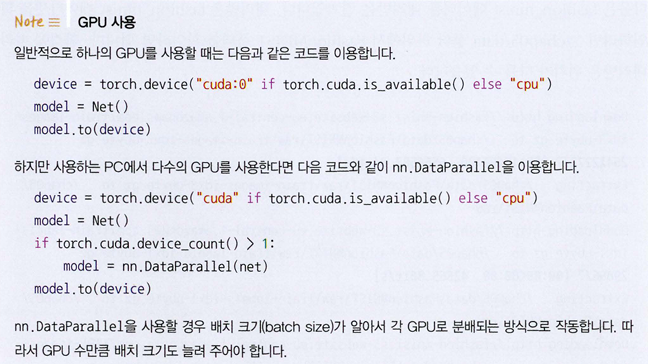

In [3]:
# fashion_mnist 데이터셋 내려받기
# 추가 코드
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
train_dataset= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)
test_dataset=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.60MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 138kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.25MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.11MB/s]


In [4]:
# 교재 코드
# train_dataset = torchvision.datasets.FashionMNIST("../chap05/data",download=True,transform=transforms.Compose([transforms.ToTensor()]))
# test_dataset = torchvision.datasets.FashionMNIST("../chap05/data",download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))
# 앞에서 훈련 데이터셋을 내려받았으면 테스트 데이터셋 내려받기


- 첫 번쨰 파라미터: fashionMNIST를 내려받을 위치 지정
- download: download를 True로 변경해 주면 첫 번쨰 파라미터의 위치에 해당 데이터셋이 있는지 확인한 후 내려받음.
- transform: 이미지를 텐서(0~1)로 변경

In [5]:
# fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

- 첫 번쨰 파라미터: 데이터를 불러올 데이터셋을 지정
- batch_size = 데이터를 배치로 묶어줌, 여기에서는 batch_size=100으로 지정했기 때문에 100개 단위로 데이터를 묶어서 불러옴.


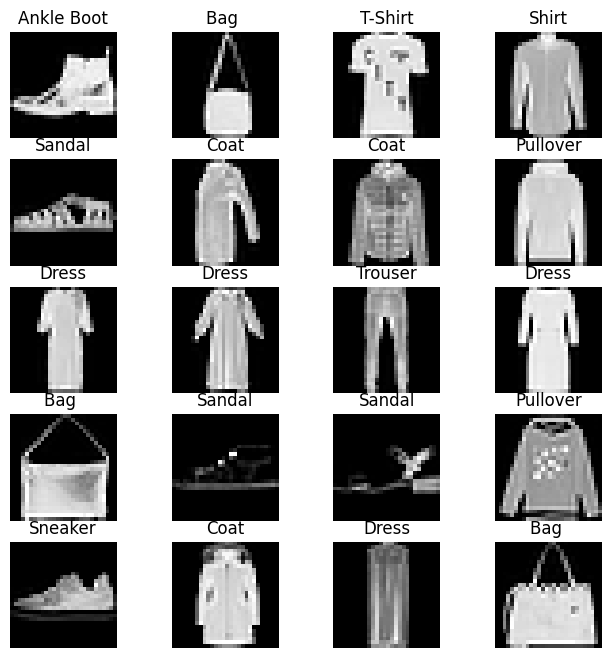

In [6]:
# 분류에 사용될 클래스 정의
labels_map = {0:'T-Shirt',1:'Trouser',2:'Pullover',3:'Dress' ,4:'Coat',
5 : 'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag ', 9:'Ankle Boot'} # 10개의 클래스

fig = plt.figure(figsize=(8,8)); # 출력할 이미지의 가로 세로 길이로 단위는 inch
columns = 4;
rows = 5;
for i in range(1, columns*rows + 1):
  img_xy = np.random.randint(len(train_dataset));
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show() # 20개의 이미지 데이터를 시각적으로 표현

1. np.random은 무작위로 데이터를 생성할 떄 사용, np.random.randint()는 이산형 분포를 갖는 데이터에서 무작위 표본을 추출할 떄 사용

In [7]:
import numpy as np
np.random.randint(10) # 0~10의 임의의 숫자를 출력
np.random.randint(1,10) # 1~9의 임의의 숫자를 출력
np.random.rand(8) # 0~1 사이의 정규표준분포 난수를 행렬로 (1*8) 출력

array([0.39187237, 0.41443866, 0.84255407, 0.81250836, 0.16771165,
       0.92705195, 0.98936516, 0.25159192])

In [8]:
np.random.rand(4,2) # 0~1 사이의 정규표준분포 난수를 행렬로 4*2 출력

array([[0.55128563, 0.85055615],
       [0.95115949, 0.28933101],
       [0.53518903, 0.76626203],
       [0.35367369, 0.15228231]])

In [9]:
np.random.randn(8) # 평균이 0이고, 표준편차가 1인 가우시안 정규분포 난수를 행렬로 4*2 출력

array([-1.06428809,  0.41111166,  0.41749866, -0.20772372,  0.82869156,
       -0.65350328,  1.40738494, -1.09823541])

In [10]:
import numpy as np
examp = np.arange(0, 100, 3) # 1~99의 숫자에서 3씩 건너뛴 행렬을 생성
examp.resize(6,4) # 행렬의 크기를 6*4로 조정
examp

array([[ 0,  3,  6,  9],
       [12, 15, 18, 21],
       [24, 27, 30, 33],
       [36, 39, 42, 45],
       [48, 51, 54, 57],
       [60, 63, 66, 69]])

In [11]:
examp[3] # 3행에 해당하는 모든 요소(값)들을 출력(행과 열은 0부터 시작)

array([36, 39, 42, 45])

In [12]:
examp[3,3] # 3행의 3번쨰 열에 대한 값(요소)를 출력

np.int64(45)

In [13]:
examp[3][3] # 3행의 3번쨰 열에 대한 값(요소)를 출력하기 때문에 바로 앞의 결과와 동일

np.int64(45)

- train_datase[img_xy][0][0,:,:] 의미는 다음 예시로 출력 결과를 유추해 볼 수 있음.





In [14]:
import numpy as np
examp = np.arange(0, 500, 3)
examp.resize(3,5,5)
examp

array([[[  0,   3,   6,   9,  12],
        [ 15,  18,  21,  24,  27],
        [ 30,  33,  36,  39,  42],
        [ 45,  48,  51,  54,  57],
        [ 60,  63,  66,  69,  72]],

       [[ 75,  78,  81,  84,  87],
        [ 90,  93,  96,  99, 102],
        [105, 108, 111, 114, 117],
        [120, 123, 126, 129, 132],
        [135, 138, 141, 144, 147]],

       [[150, 153, 156, 159, 162],
        [165, 168, 171, 174, 177],
        [180, 183, 186, 189, 192],
        [195, 198, 201, 204, 207],
        [210, 213, 216, 219, 222]]])

In [15]:
examp[2][0][3]

np.int64(159)

- 합성곱 신경망과 합성곱 신경망이 아닌 심층 신경망의 비교를 위해 먼저 심층 신경망을 생성한 후 학습, ConvNet이 적용되지 않은 네트워크 만들기

In [16]:
# 심층 신경망 모델 생성
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data):
    out = input_data.view(-1, 784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

(1) class 형태의 모델은 항상 torch.nn.Module을 상속받음.
  - __init__()은 객체가 갖는 속성 값을 초기화하는 역할을 하며, 객체가 생성될 떄 자동으로 호출.
  - super(FashionDNN, self).__init__()은 nn.Module 클래스를 상속받겠다는 의미로 이해

(2) nn은 딥러닝 모델(네트워크) 구성에 필요한 모듈이 모여 있는 패키지이며, Linear은 단순 선형 회귀 모델에 만들 때 사용함.
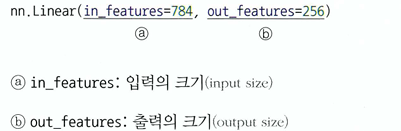

    - 실제로 연산이 진행되는 forward() 부분에서 첫 번째 파라미터 값만 넘겨주게 되며, 두번째 파라미터에서 정의된 크기가 forward() 연산의 결과가 됨.

(3) torch.nn.Dropout(p)는 p만큼의 비율로 텐서의 값이 0이되고, 0이 되지 않은 값들은 기존 값에 (1/(1-p))만큼 곱해서 커짐.

(4) forward() 함수는 모델이 학습 데이터를 입력받아서 순전파 학습을 진행시키며, 반듯이 forward라는 이름의 함수여야 함. 즉, forward()는 모델이 학습 데이터를 입력받아서 순전파 연산을 진행하는 함수이며, 객체를 데이터와 함께 호출하면 자동으로 실행됨. 이때 순전파 연산이란 H(x)^2 식에 입력 x로부터 예측된 y를 얻는 것임.

(5) 파이토치에서 사용하는 뷰는 넘파이의 reshape과 같은 역할로 텐서의 크기(shape)를 변경해 주는 역할을 수행.
  - 따라서 input_data.view(-1, 784)는 input_data를 (?, 784)의 크기로 변경하라는 의미, 즉 2차원 텐서로 변경하되 (?, 784)의 크기로 변경하라는 의미임.

(6) 활성화 함수를 지정할 때는 다음 두가지 방법이 가능

  - F.relu(): forward() 함수에서 정의
  - nn.ReLU(): __init__() 함수에서 정의

  -> 활성화 함수 사용에 한정하여 이 둘 간의 차이는 간단히 사용하는 위치라고 할 수 있음.


In [17]:
import torch
import torch.nn as nn

inputs = torch.randn(64, 3, 244, 244)
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1) # 3개의 채널이 입력되어 64개의 채널이 출력되기 위한 연산으로 3*3 크기의 커널을 사용
outputs = conv(inputs)
layers = nn.Conv2d(1,1,3)

In [18]:
inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64, 3, 3, 3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weight, bias, padding=1)

- nn.Conv2d에서 input_channel과 output_channel을 사용해 연산했다면 functional.conv2d는 입력과 가중치 자체를 직접 넣어줘야 함. (가중치를 전달해야 할 때 가중치 값을 새로 정의해야 함.)


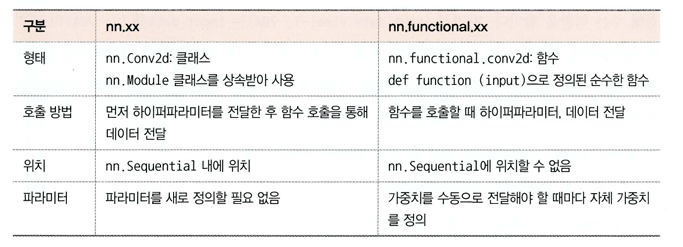

In [19]:
# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


(1) 옵티마이저를 위한 경사 하강법은 Adam을 사용하며, 학습률을 의미하는 lr은 0.001을 사용

In [20]:
# 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = []    # (1)
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:   # (2)
        images, labels = images.to(device), labels.to(device)   # (3)

        train = Variable(images.view(100, 1, 28, 28))   # (4)
        labels = Variable(labels)

        outputs = model(train)   # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):    # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))

                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = correct * 100 / total   # (5)
            loss_list.append(loss.data)        # (1')
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5668513178825378, Accuracy: 83.11000061035156%
Iteration: 1000, Loss: 0.490474134683609, Accuracy: 84.5199966430664%
Iteration: 1500, Loss: 0.35473406314849854, Accuracy: 84.5999984741211%
Iteration: 2000, Loss: 0.38917362689971924, Accuracy: 85.4800033569336%
Iteration: 2500, Loss: 0.24575094878673553, Accuracy: 86.16999816894531%
Iteration: 3000, Loss: 0.2850872874259949, Accuracy: 85.9800033569336%


1-1. 일반적으로 배열이나 행렬과 같은 리스트를 사용하는 방법은 다음과 같음.
  - 1과 같이 비어있는 배열이나 행렬을 만듦.
  - 1'처럼 append 메서드를 이용하여 데이터를 하나씩 추가

2. for 구분을 사용하여 레코드(행, 가로줄)을 하나씩 가져옴. 이때, for x, y in train:과 같이 in 앞에 변수를 두개 지정해 주면 레코드에서 요소 두개를 꺼내 오겠다는 의미

3. 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야 함. 코드 5-7에서 model.to(device)가 GPU를 사용했다면, labels, to(device)도 GPU에서 처리되어야 함.

4. Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지로 자동 미분에 대한 값을 저장하기 위해 테이프를 사용, 순전파 단계에서 테이프는 수행하는 모든 연산을 저장, 그리고 역전파 단계에서 저장된 값들을 꺼내서 사용, 즉 Autograd는 Variable을 사용해서 역전파를 위한 미분 값을 자동으로 계산, 따라서 자동 미분을 계산하기 위해서는 torch.autograd 패키지 안에 있는 variable을 이용해야 동작

5. 분류 문제에 대한 정확도는 전체 예측에 대한 정확한 예측의 비율로 표현할 수 있으며 코드는 다음과 같음.
classification accuracy = correct predictions/total predictaions

# 결과에 100을 곱하여 백분율로 표시
classification accuacy = correct predictions / total predictions * 100

# 값을 반전시켜 오분류율 또는 오류율로 표현
error rate = (1-(correct predictions / total predictions))*100

- 분류 문제에서 클래스가 3개이상일 떄는 다음과 같은 사항에 주의

  - 정확도가 80%이상이라면 80%가 모든 클래스에 동등하게 고려된 것인지 특정 클래스의 분류가 높았떤 것인지에 대해 알 수 없음에 유의
  - 정확도가 90%일 떄, 100개의 데이터 중 90개가 하나의 클래스에 속할 경우 90%의 정확도는 높다고 할 수 없음. 즉 모든 데이터를 특정 클래스에 속한다고 예측해도 90%의 예측 결과가 나오기 때문에 데이터 특성에 따라 정확도를 잘 관측해야 할 필요가 있음

- 결과 코드:
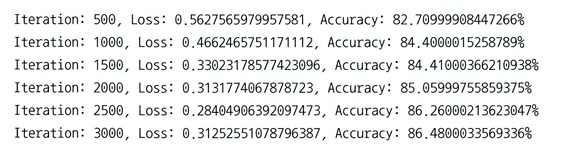

In [21]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(    # (1)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),   # (2)
            nn.BatchNorm2d(32),   # (3)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # (4)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)   # (5)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)   # 마지막 계층의 out_features는 클래스 개수를 의미

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


1. nn.Sequential을 사용하면 __init__()에서 사용할 네트워크 모델을 정의해 줄 뿐만 아니라 forward() 함수에서 구현될 순전파를 계층 형태로 좀 더 가독성이 뛰어난 코드로 작성

2. 합성곱층은 합성곱 연산을 통해서 이미지의 특징을 추출, 합성곱이란 커널이라는 n*m 크기의 행렬이 높이*너비 크기의 이미지를 처음부터 끝까지 훑으면서 각 원소 값끼리 곱한 후 모두 더한 값을 출력

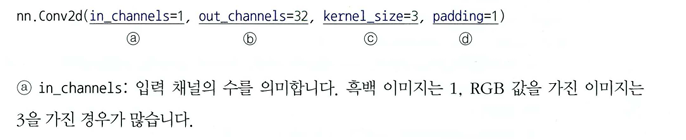

- 채널이란? 3차원으로 생각하면 깊이를 의미함.
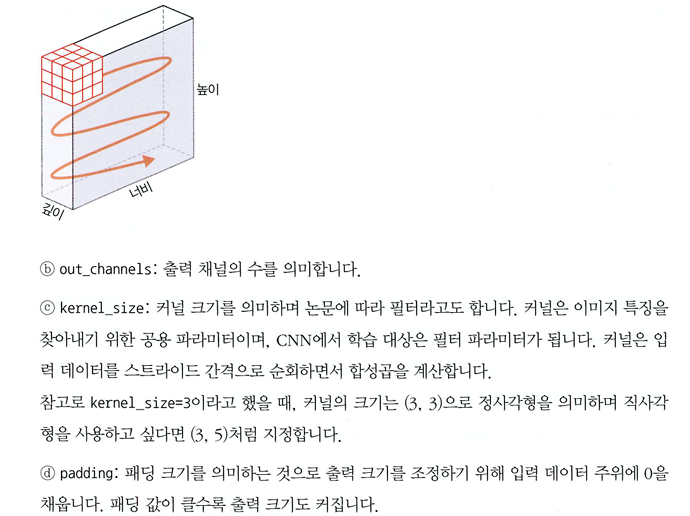

3. BatchNorm2d는 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것을 의미

4. MaxPool2d는 이미지 크기를 축소시키는 용도로 사용, 풀링 계층은 합성곱층의 훌력 데이터를 입력으로 받아서 출력 데이터의 크기를 줄이거나 특정 데이터를 강조하는 요도로 사용
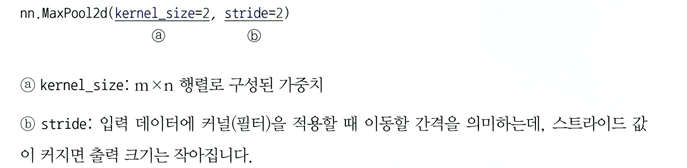

5. 클래스를 분류하기 위해서는 이미지 형태의 데이터를 배열 형태로 변환하여 작업해야함. Conv2d에서 사용하는 하이퍼파라미터의 값들에 따라 출력크기가 달라짐.

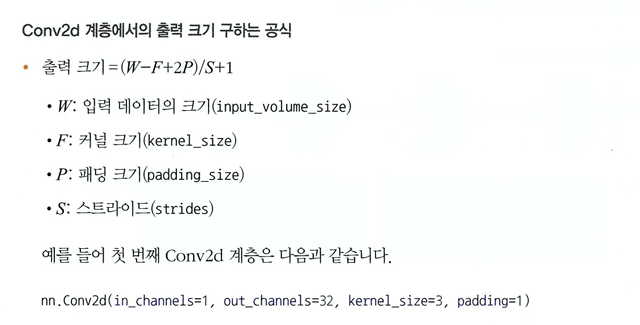

In [22]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [23]:
# 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)   # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):    # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))

                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4835239052772522, Accuracy: 87.70999908447266%
Iteration: 1000, Loss: 0.3240828812122345, Accuracy: 88.69999694824219%
Iteration: 1500, Loss: 0.3271801769733429, Accuracy: 88.0%
Iteration: 2000, Loss: 0.17909806966781616, Accuracy: 89.12000274658203%
Iteration: 2500, Loss: 0.16449472308158875, Accuracy: 89.86000061035156%
Iteration: 3000, Loss: 0.1947786509990692, Accuracy: 90.01000213623047%


-> 심층 신경망과 비교하여 정확도가 약간 높으나 이미지 데이터가 많아지면 단순 심층신경망으로는 정확한 특성 추출 및 분류가 불가능하므로 합성곱 신경망을 생성할 수 있도록 학습해야 함.